# Importing Packages and Defining Helper Functions

In [1]:
# Used to get statistics for preprocessing
from osgeo import gdal


# import torch and other necessary modules from torch
# https://docs.google.com/document/d/1e3Ybe0KQFmSzbsqRl8o9f-PeWsv5nUrKLBrTgH-Ywsc/edit
import torch
import torch.nn as nn

# import torchvision and other necessary modules from torchvision 
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as figure
from matplotlib.gridspec import GridSpec

from sklearn.metrics import r2_score, mean_squared_error
from torch.utils.data import Dataset, DataLoader
import os
import math
from PIL import Image


#### Helper Functions / Classes

In [2]:
# Constants to use later in the script
PATH_TO_TILED_IMGS = "D:\ICEEYE\Proposal_ID_PP0091278\CS-13801\SLEA_3279211_180312\Ice-Sat-Tiles"
SAR_REF = "D:\ICEEYE\Proposal_ID_PP0091278\CS-13801\SLEA_3279211_180312\SLEA-Repojected-WSG84.tiff"
BATCH_SIZE = 16            # How many random sampled tiles to pull for each iteration of training

# Label parser used when previewing the input data 
def parseLabel(filename: str):
    index, file = filename.split("-")
    basename = file.replace(".png", "")
    return (index, basename)

# Custom tiled dataset class
class SARTile(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_list = os.listdir(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image_path = os.path.join(self.data_dir, image_name)
        image = Image.open(image_path)
        pixels = list(image.getdata())
        print(min(pixels), max(pixels))

        if self.transform:
            image = self.transform(image)

        index, image_name = parseLabel(image_name)
            
        return (image, float(image_name), index)

#### Loading Data + Setting Preprocessing Steps

In [3]:
# Reference to the SAR image that our dataset was tiled from
SAR = gdal.Open(SAR_REF)

# Calculating the global stats of the file to preprocess our tiles
tiffMin, tiffMax, tiffMean, tiffStDev = SAR.GetRasterBand(1).GetStatistics(0,1)                         # Make sure that this s calculating the stats of only the sar, not the black edge
print(tiffMin, tiffMax, tiffMean, tiffStDev)

# IceSat beam data. Note: Labeling was done in the tiling script, this reading is just for stats.
beam_data = pd.read_csv("D:/ICEEYE/Proposal_ID_PP0091278/CS-13801/SLEA_3279211_180312/ATL10QL-01_20240119042539_04792201_006_01.h5.csv")
fbh_mean = beam_data[['gt1rFBH', 'gt1lFBH', 'gt2rFBH', 'gt2lFBH', 'gt3rFBH', 'gt3lFBH']].mean()         # Calculates the mean beam measure of each laser
fbh_mean = fbh_mean.mean()                                                                              # Calculates the mean of means
beam_data = None                                                                                        # Closes the df

# Defining the images as grayscale, converting it to a tensor, adding random flips and rotations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # We know the inputs are greyscale
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=tiffMean,
    #     std=tiffStDev
    # )
])

0.0 52182.0 839.82720229523 953.31374383473



#### Read Data and set Train/Test splits

3752
939


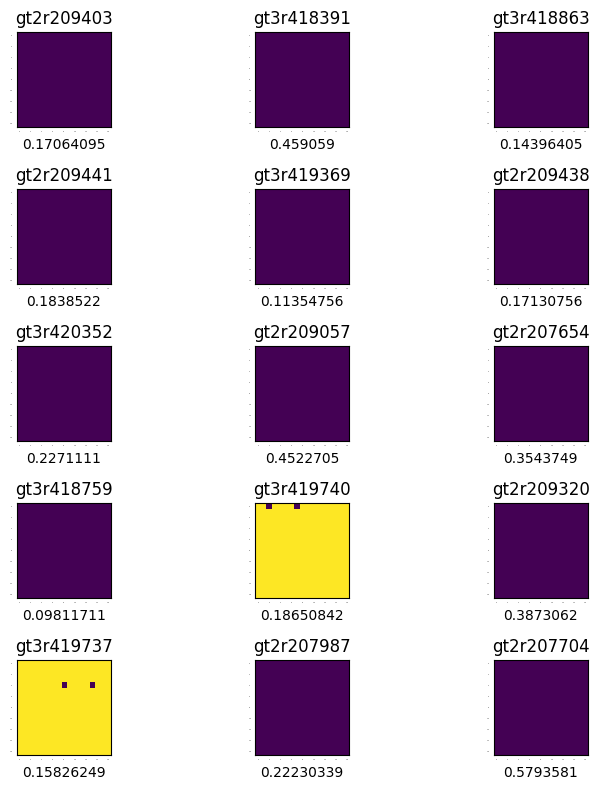

In [4]:
# Reading in the dataset using the custom class defined above
dataset = SARTile(data_dir = PATH_TO_TILED_IMGS, transform=transform)

# 80/20 split of train/test 
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
print(train_size)
print(test_size)
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

# prepare dataloader for training set and evaluation set
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

# Visualizing some of the testing data
fig, axs = plt.subplots(5, 3, figsize=(8,8))
i = 0
for ax in axs.flat:
    img, label, index = train_set[i]
    ax.set_title(index)
    ax.set_xlabel(label)
    ax.set_ylabel("")
    ax.tick_params(which="both", length=0, width=0, labelsize=0)
    ax.imshow(img.squeeze(), cmap="viridis") #cmap="gray"
    i += 1

plt.tight_layout()
plt.show()

# CNN Architecture
Ideas to toy with:  
&emsp;1 Analyzing pattern of speckle (should avoid pooling and rely instead on convolutions)  
&emsp;2 Analyze brightness of values (would likely need to pool, because we agree we should hold weight here)       
&emsp;3 More outchannels lets the model potentially learn more from the feature  
&emsp;&emsp;- https://stackoverflow.com/questions/56652204/pytorch-convolution-in-channels-and-out-channels-meaning  
&emsp;4 Batch norming?  
&emsp;5 Dropout?

In [144]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        # Dilation size (d) shrink the feature space by 2*d
        self.conv1 = nn.Conv2d(1, 16, 3, dilation=2) # 1 channel, outputting 16 channels, kernel size of 3 with dilation    Input of 17 w/o pooling -> 13
        self.conv2 = nn.Conv2d(16, 32, 3, dilation=2) # 16 input channels, outputting to 32 channels, kernel size of 3 w dilation   Input of 15 w/o pooling -> 9
        
        self.avgPool = nn.AvgPool2d(2,2)
        self.maxPool = nn.MaxPool2d(2,2)

        # Consider using global averaging for these outputs instead of all fully connected layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

        self.fcTest = nn.Linear(9 * 9 * 32, 1)


    def forward(self, x):
        # Convolve, rectify
        x = F.relu(self.conv1(x))

        # Maxpool
        # x = self.maxPool(x)
        
        # Insert batch norm between convolutions here

        # Convolve, rectify
        x = F.relu(self.conv2(x))
        
        # maxpool
        # x= self.maxPool(x)
        
        # Flatten
        x = torch.flatten(x, 1) # flatten
        
        # Send to fully connected layers
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        
        # Flatten down to 1 value, and return it's tensor
        x = self.fcTest(x)
        return x.flatten()

device = 'cuda' if torch.cuda.is_available() else 'cpu' # whether your device has GPU
print(device)
cnn = CNN().to(device) # move the model to GPU

cpu


In [147]:
##### HELPER FUNCTION FOR FEATURE EXTRACTION (ty to https://kozodoi.me/blog/20210527/extracting-features)
# placeholders
INPUTS = []
OUTPUTS = []
C1_FEATS = []
C2_FEATS = []

# placeholder for batch features
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

cnn.conv1.register_forward_hook(get_features('conv1'))
cnn.conv2.register_forward_hook(get_features('conv2'))


#### Training

0.18590743839740753
[1,    10] loss: 0.095
[1,    20] loss: 0.059
[1,    30] loss: 0.048
[1,    40] loss: 0.042
[1,    50] loss: 0.038
[1,    60] loss: 0.035
[1,    70] loss: 0.032
[1,    80] loss: 0.031
[1,    90] loss: 0.030
[1,   100] loss: 0.030
[1,   110] loss: 0.028
[1,   120] loss: 0.029
[1,   130] loss: 0.028
[1,   140] loss: 0.028
[1,   150] loss: 0.027
[1,   160] loss: 0.027
[1,   170] loss: 0.027
[1,   180] loss: 0.027
[2,    10] loss: 0.026
[2,    20] loss: 0.022
[2,    30] loss: 0.023
[2,    40] loss: 0.022
[2,    50] loss: 0.022
[2,    60] loss: 0.023
[2,    70] loss: 0.024
[2,    80] loss: 0.024
[2,    90] loss: 0.023
[2,   100] loss: 0.023
[2,   110] loss: 0.023
[2,   120] loss: 0.023
[2,   130] loss: 0.022
[2,   140] loss: 0.023
[2,   150] loss: 0.022
[2,   160] loss: 0.022
[2,   170] loss: 0.022
[2,   180] loss: 0.022
[3,    10] loss: 0.022
[3,    20] loss: 0.019
[3,    30] loss: 0.020
[3,    40] loss: 0.021
[3,    50] loss: 0.023
[3,    60] loss: 0.023
[3,    70] los

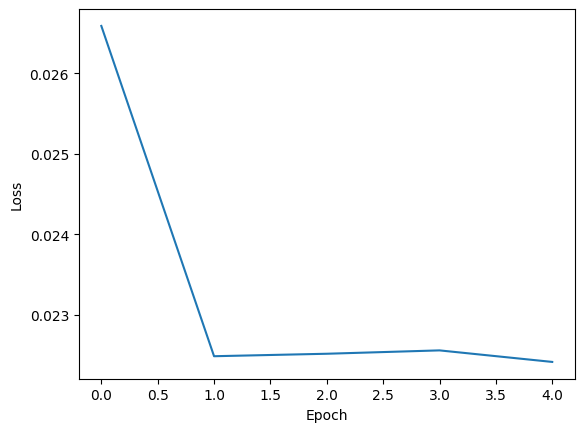

In [148]:
# Reset the training weights whenever we run the training again
for layer in cnn.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

criterion = nn.MSELoss()
# try Adam optimizer (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) with learning rate 0.0001, feel free to use other optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=.0001)

# Training
# model hyperparameter
learning_rate = 0.001
epoch_size = 5

loss_arr = []
cnn.train() # turn on train mode, this is a good practice to do
for epoch in range(epoch_size): # begin with trying 10 epochs 

    loss = 0.0 
    running_loss = 0.0 # you can print out average loss per batch every certain batches
    for i, data in enumerate(trainloader, 0):
        # get the inputs and label from dataloader
        inputs, labels, _ = data


        # Convert the float values into long
        labels = labels.float()
        
        # move tensors to your current device (cpu or gpu)
        INPUTS.append(inputs.numpy())
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients using zero_grad()
        optimizer.zero_grad()
        
        # forward -> compute loss -> backward propogation -> optimize (see tutorial mentioned in main documentation)
        outputs = cnn(inputs)

        # add feats and outputs to lists
        OUTPUTS.append(outputs.detach().cpu().numpy())
        C1_FEATS.append(features['conv1'].cpu().numpy())
        C2_FEATS.append(features['conv2'].cpu().numpy())

        curLoss = criterion(outputs, labels)
        curLoss.backward()
        optimizer.step()

        # print some statistics
        loss =  curLoss.item()
        if i == 0 and epoch == 0:
            print(loss)
        running_loss += loss
        if i % 10 == 9:    # print out average loss every 100 batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i:.3f}')

        # We can add an early stop condition here
        # if _____:
        #    break
    loss_arr.append(running_loss / len(trainloader))
            
OUTPUTS = np.concatenate(OUTPUTS)
C1_FEATS = np.concatenate(C1_FEATS)
C2_FEATS = np.concatenate(C2_FEATS)

plt.plot(loss_arr, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
print('Finished Training')

- outputs shape: (14700,)
- c1 feats shape: (14700, 16, 13, 13)
- c2 feats shape: (14700, 32, 9, 9)
16
32
16
32
(16, 1, 17, 17)


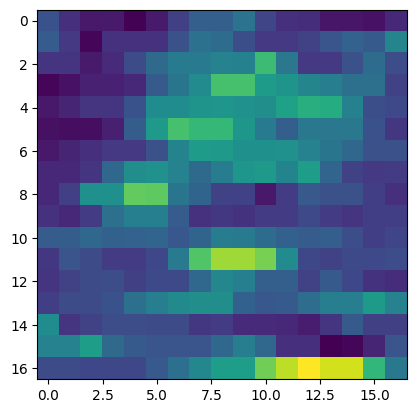

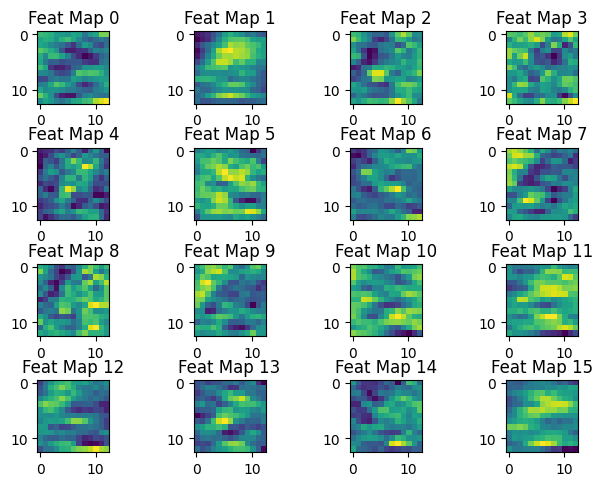

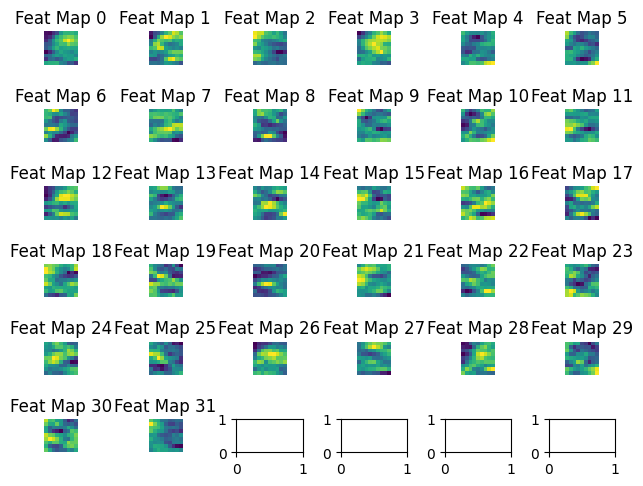

In [149]:
print('- outputs shape:', OUTPUTS.shape)
print('- c1 feats shape:', C1_FEATS.shape)
print('- c2 feats shape:', C2_FEATS.shape)


print(len(features['conv1'][0]))
print(len(features['conv2'][0]))

first_input_c1 = C1_FEATS[0]          # This is a dictionary of all inputs passed through our first convolution. This gets the first one
first_input_c2 = C2_FEATS[0]          # This is a dictionary of all inputs passed through our second convolution. This gets the first one
print(len(first_input_c1))
print(len(first_input_c2))


num_feat_maps_c1 = first_input_c1.shape[0]  # Conv 1 results in 16 feature maps of size 13x13
sub_graph_dim_c1 = math.ceil(math.sqrt(num_feat_maps_c1))

num_feat_maps_c2 = first_input_c2.shape[0]  # Conv 2 results in 16 feature maps of size 13x13
sub_graph_dim_c2 = math.ceil(math.sqrt(num_feat_maps_c2))


print(INPUTS[0].shape)       # Shape of a training iteration (inputs[index] is an iteration) * batch size * # channels * width * height
plt.imshow(INPUTS[0][0][0])#, interpolation="spline16")         # This nesting is accessing the first image of the first batch of the first training iteration

# using the variable axs for multiple Axes
fig, ax = plt.subplots(sub_graph_dim_c1, sub_graph_dim_c1)
fig.tight_layout()
count = 0
for i, x in enumerate(ax):
    for j, y in enumerate(x):
        ax[i, j].imshow(first_input_c1[count])#, interpolation="spline16")
        # ax[i, j].set_axis_off()
        ax[i, j].set_title(f'Feat Map {count}')
        count = count + 1

fig, ax = plt.subplots(sub_graph_dim_c2, sub_graph_dim_c2)
fig.tight_layout()
count = 0
for i, x in enumerate(ax):
    for j, y in enumerate(x):
        if(count < len(first_input_c2)):
            ax[i, j].imshow(first_input_c2[count])#, interpolation="spline16")
            ax[i, j].set_axis_off()
            ax[i, j].set_title(f'Feat Map {count}')
            count = count + 1


#### Testing


===0==
Actual: 0.1960598723076923
Predicted: 0.32676056027412415
Diff: -0.13070068796643183
===10==
Actual: 0.4372067463636364
Predicted: 0.31729260087013245
Diff: 0.11991414549350393
===20==
Actual: 0.4064203310526316
Predicted: 0.3185711205005646
Diff: 0.08784921055206701
===30==
Actual: 0.3262508673333333
Predicted: 0.28525620698928833
Diff: 0.040994660344044975
===40==
Actual: 0.049737327250000005
Predicted: 0.2896936535835266
Diff: -0.2399563263335266
===50==
Actual: 0.21418539500000003
Predicted: 0.330424040555954
Diff: -0.11623864555595395
===60==
Actual: 0.6037177933333334
Predicted: 0.34920060634613037
Diff: 0.25451718698720305
===70==
Actual: 0.15250340473684207
Predicted: 0.27681073546409607
Diff: -0.124307330727254
===80==
Actual: 0.19649224857142858
Predicted: 0.31420451402664185
Diff: -0.11771226545521327
===90==
Actual: 0.33470859682352944
Predicted: 0.3179723620414734
Diff: 0.016736234782056048
===100==
Actual: 0.267781702
Predicted: 0.31216931343078613
Diff: -0.0443876

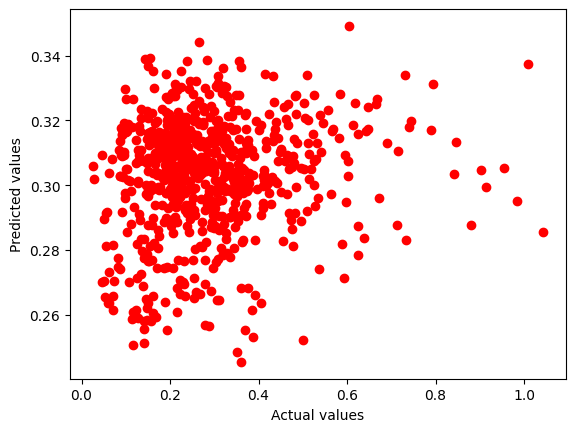

In [150]:
# evaluation on evaluation set
ground_truth = []
prediction = []
cnn.eval() # turn on evaluation model, also a good practice to do

cnn.train(mode=False)
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs, so turn on no_grad mode
    for i, data in enumerate(testloader, 0):
        inputs, labels, _ = data
        inputs = inputs.to(device)
        ground_truth += list(labels)    # convert labels to list and append to ground_truth
        # calculate outputs by running inputs through the network
        outputs = cnn(inputs)
        predicted = outputs.detach().cpu().flatten()
#         print(predicted.tolist())
        prediction.extend(predicted.tolist()),

totErr = 0
for i in range(len(ground_truth)):
    err = ground_truth[i].item() - prediction[i]
    totErr += err
    if i % 10 == 0:
        print(f"==={i}==")
        print(f"Actual: {ground_truth[i]}")
        print(f"Predicted: {prediction[i]}")
        print(f"Diff: {err}")

print(f"Cumulative err: {totErr}")
print("=============")
r2score = r2_score(y_true=ground_truth, y_pred=prediction)
mse = mean_squared_error(y_true=ground_truth, y_pred=prediction)
rmse = math.sqrt(mse)
n_rmse = rmse / (max(ground_truth) - min(ground_truth))
print(f"R2: {r2score}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"NORM RMSE: {n_rmse}")


ground_truth_nums = [x.item() for x in ground_truth]
# print(ground_truth_nums)
plt.plot(ground_truth_nums, prediction, 'ro')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

plt.show()

#### Re-evaluating the input data

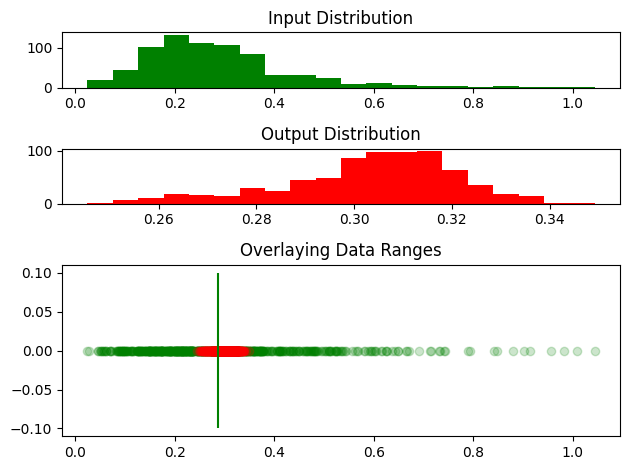

In [151]:
fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[2:4, 0:4])
ax_hist_output = fig.add_subplot(gs[1,0:4])
ax_hist_input = fig.add_subplot(gs[0, 0:4])

ax_scatter.scatter(ground_truth_nums,  np.zeros(len(ground_truth_nums)), color='green', alpha=0.2)
ax_scatter.scatter(prediction, np.zeros(len(prediction)), color='red', alpha=0.2)
ax_scatter.vlines(sum(ground_truth_nums) / len(ground_truth_nums), ymin=-0.1, ymax=0.1,colors="green")
ax_scatter.set_title("Overlaying Data Ranges")


ax_hist_input.hist(ground_truth_nums, bins=20, color='green')
ax_hist_input.set_title("Input Distribution")
ax_hist_output.hist(prediction, bins=20, color='red')
ax_hist_output.set_title("Output Distribution")
fig.tight_layout()
plt.show()
